### Compressed Sensing Tutorial

This notebook and the PyLBFGS library was developed by Robert Taylor (http://www.pyrunner.com/weblog/2016/05/26/compressed-sensing-python/). All steps are noted and explained in the markdown there. I don't do much of any explanation here.

Original limited-memory method of BFGS developed by Jorge Nocedal (http://www.ams.org/journals/mcom/1980-35-151/S0025-5718-1980-0572855-7/home.html)

C implementation thereof by Naoaki Okazaki (http://www.chokkan.org/software/liblbfgs/)

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from pylbfgs import owlqn

In [3]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

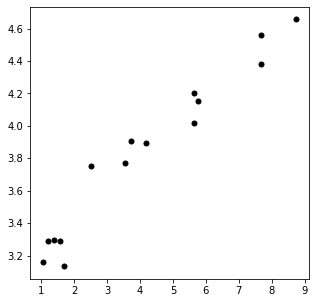

In [4]:
plt.figure(figsize=(5,5))
plt.plot(x,y,linewidth=0,marker='.',color='k',markersize=10);

In [5]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 1.304613
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 0.185311
         Iterations: 51
         Function evaluations: 100


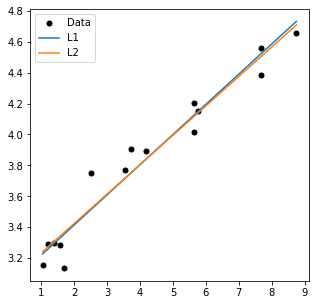

In [6]:
plt.figure(figsize=(5,5))
plt.plot(x,y,linewidth=0,marker='.',color='k',markersize=10,label='Data')
plt.plot(x, x*xopt1[0] + xopt1[1],label='L1')
plt.plot(x, x*xopt2[0] + xopt2[1],label='L2')
plt.legend();

In [7]:
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))

Optimization terminated successfully.
         Current function value: 8.172769
         Iterations: 52
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 20.821242
         Iterations: 49
         Function evaluations: 94


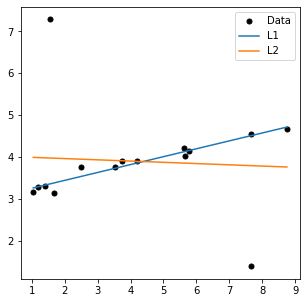

In [8]:
plt.figure(figsize=(5,5))
plt.plot(x,y2,linewidth=0,marker='.',color='k',markersize=10,label='Data')
plt.plot(x, x*xopt12[0] + xopt12[1],label='L1')
plt.plot(x, x*xopt22[0] + xopt22[1],label='L2')
plt.legend();

In [9]:
# sum of three sinusoids
f1 = 300
f2 =950
f3 = 1200
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(f1 * np.pi * t) + np.sin(f2 * np.pi * t) + np.sin(f3 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

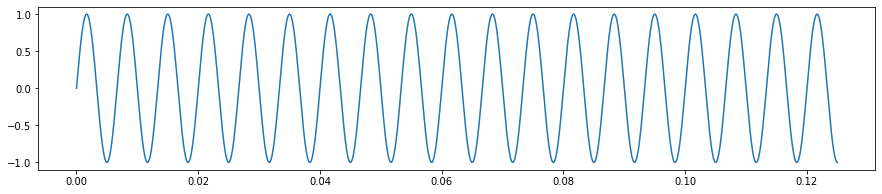

In [10]:
plt.figure(figsize=(15,3))
plt.plot(t,np.sin(f1 * np.pi * t));

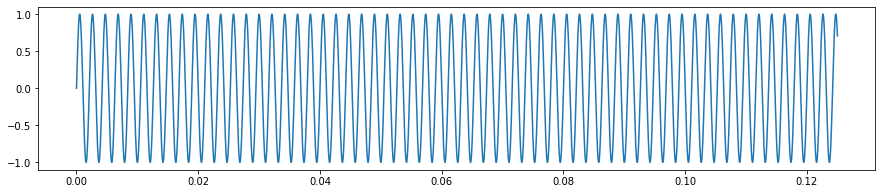

In [11]:
plt.figure(figsize=(15,3))
plt.plot(t,np.sin(f2 * np.pi * t));

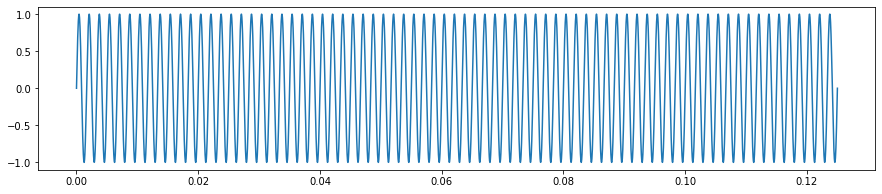

In [12]:
plt.figure(figsize=(15,3))
plt.plot(t,np.sin(f3 * np.pi * t));

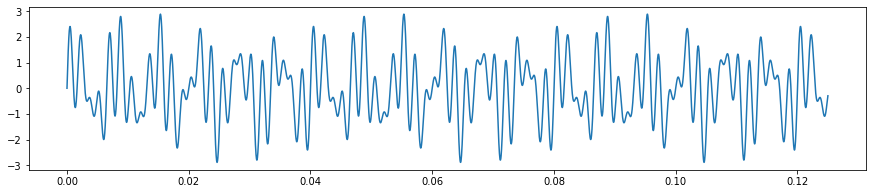

In [13]:
plt.figure(figsize=(15,3))
plt.plot(t,y);

(0, 0.005)

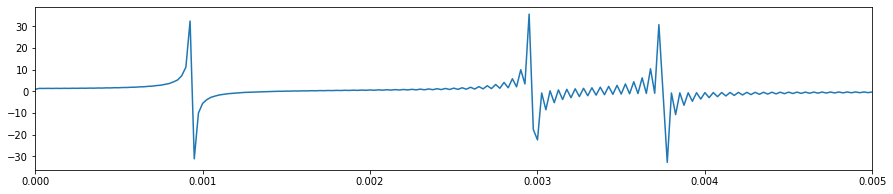

In [14]:
plt.figure(figsize=(15,3))
plt.plot(t,yt)
plt.xlim((0,0.005))

In [15]:
m = 250 # 5% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

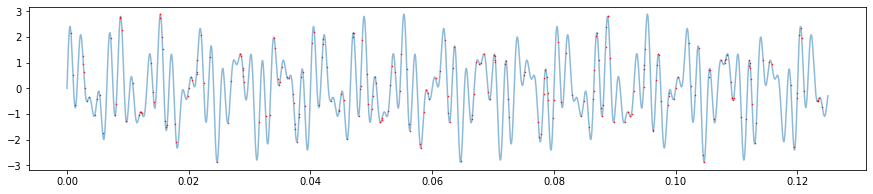

In [16]:
plt.figure(figsize=(15,3))
plt.plot(t,y,alpha=0.5);
plt.plot(t2,y2,linewidth=0,marker='.',markersize=1,color='red');

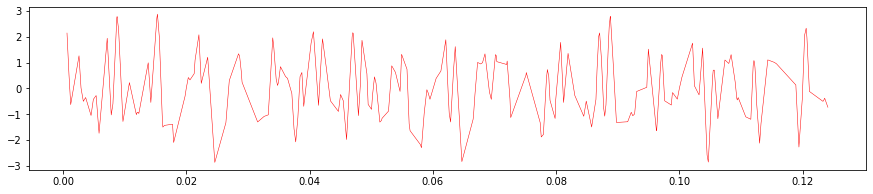

In [17]:
plt.figure(figsize=(15,3))
plt.plot(t2,y2,linewidth=0.5,color='red');

In [18]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 10000, constraints m = 10250
          nnz(P) + nnz(A) = 1269848
settings: linear system solver = qdldl,
          eps_abs = 1.0e-04, eps_rel = 1.0e-04,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -4.0000e+04   8.00e+00   4.66e+05   1.00e-01   6.40e-01s
 200   4.1144e+02   1.11e-01   2.48e-03   1.49e-02   1.36e+00s
 400   4.1240e+02   3.74e-02   8.55e-04   1.49e-02   2

In [19]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

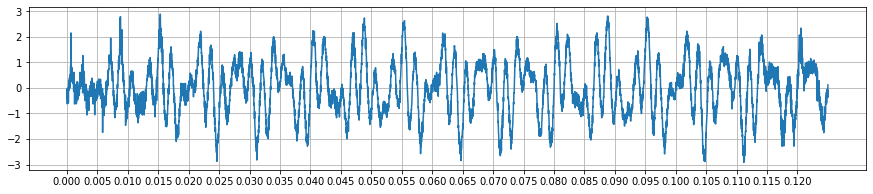

In [20]:
plt.figure(figsize=(15,3))
plt.plot(t,sig);
plt.xticks(np.arange(0,0.125,0.005))
plt.grid()

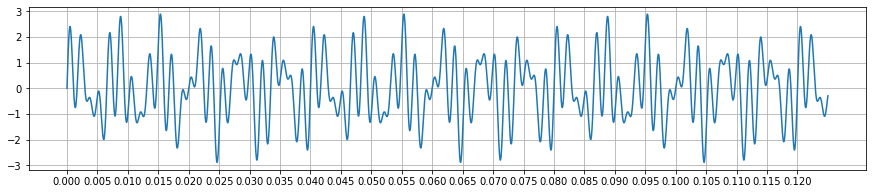

In [21]:
plt.figure(figsize=(15,3))
plt.plot(t,y);
plt.xticks(np.arange(0,0.125,0.005))
plt.grid()

Notice its a little crappy at the ends but is really accurate towards the middle.

In [22]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [31]:
# read original image and downsize for speed
def rgb2gray(rgb):
    return 256 - np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 
Xorig = rgb2gray(plt.imread('/myvol/data/puppy-dog.jpg')) # read in grayscale
X = spimg.zoom(Xorig, 0.1)
ny, nx = X.shape

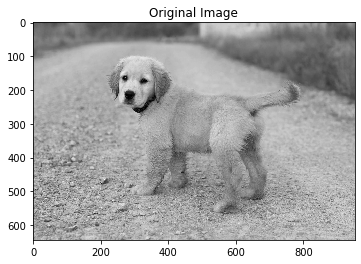

In [32]:
plt.imshow(Xorig, cmap='binary');
plt.title('Original Image');

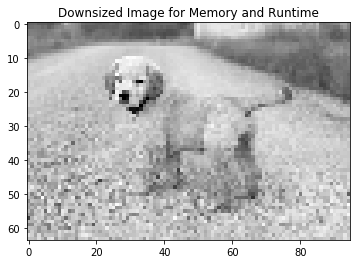

In [33]:
plt.imshow(X, cmap='binary');
plt.title('Downsized Image for Memory and Runtime');

In [34]:
# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
# b = np.expand_dims(b, axis=1)

In [35]:
# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

In [36]:
# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 12160, constraints m = 15200
          nnz(P) + nnz(A) = 18507520
settings: linear system solver = qdldl,
          eps_abs = 1.0e-04, eps_rel = 1.0e-04,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1  -4.8640e+04   2.50e+02   6.95e+08   1.00e-01   6.31e+01s
 200   6.9413e+04   1.66e-01   1.00e+00   1.00e-01   7.82e+01s
 400   6.8382e+04   5.74e-02   8.10e-03   1.00e-01   

In [37]:
# reconstruct signal
Xat = Xat2.reshape(nx, ny).T # stack columns
Xa = idct2(Xat)

In [38]:
# confirm solution
if not np.allclose(X.T.flat[ri], Xa.T.flat[ri]):
    print('Warning: values at sample indices don\'t match original.')

In [39]:
# create images of mask (for visualization)
mask = np.zeros(X.shape)
mask.T.flat[ri] = 255
Xm = 255 * np.ones(X.shape)
Xm.T.flat[ri] = X.T.flat[ri]

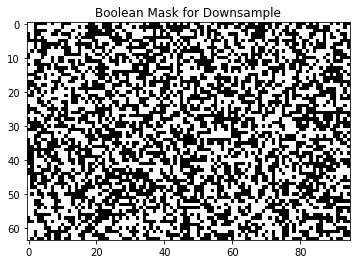

In [40]:
plt.imshow(mask, cmap='binary');
plt.title('Boolean Mask for Downsample');

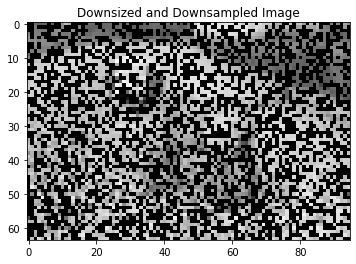

In [43]:
plt.imshow(Xm, cmap='binary');
plt.title('Downsized and Downsampled Image');

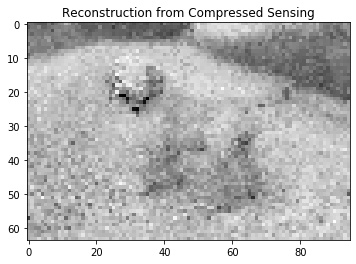

In [44]:
plt.imshow(Xa, cmap='binary');
plt.title('Reconstruction from Compressed Sensing');

In [45]:
def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

In [46]:
# fractions of the scaled image to randomly sample at
sample_sizes = (0.1, 0.01)

# read original image
# Xorig = plt.imread('/myvol/data/puppy-dog.jpg')
img = plt.imread('/myvol/data/puppy-dog.jpg')
Xorig = spimg.zoom(img,(0.5,0.5,1))
ny, nx, nchan = Xorig.shape

In [47]:
# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices

    # for each color channel
    for j in range(nchan):

        # extract channel
        X = Xorig[:,:,j].squeeze()

        # create images of mask (for visualization)
        Xm = 255 * np.ones(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:,j] = Xm

        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)

        # perform the L1 minimization in memory
        Xat2 = owlqn(nx*ny, evaluate, None, 5)

        # transform the output back into the spatial domain
        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        Z[i][:,:,j] = Xa.astype('uint8')

Iteration 1:
  fx = 359588311.991053, xnorm = 391.447914, gnorm = 37938.567098, step = 0.000026, k = 1, ls = 1

Iteration 2:
  fx = 100485327.990717, xnorm = 13258.821417, gnorm = 17307.497822, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 25202756.508696, xnorm = 23959.840736, gnorm = 1397.199559, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 24394102.099968, xnorm = 23522.732677, gnorm = 991.078261, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 23304369.843018, xnorm = 23194.543226, gnorm = 1210.224272, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 21438347.787350, xnorm = 23627.136691, gnorm = 1100.254194, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 20452889.568524, xnorm = 26764.894011, gnorm = 3447.321861, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 19810934.825385, xnorm = 23509.183823, gnorm = 2000.007885, step = 1.000000, k = 8, ls = 1

Iteration 9:
  fx = 18348949.464496, xnorm = 25969.600878, gnorm = 2052.060551, step = 0.250000, k = 9,

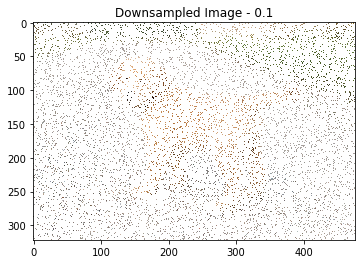

In [48]:
plt.imshow(masks[0]);
plt.title('Downsampled Image - 0.1');

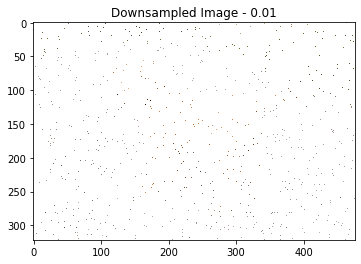

In [49]:
plt.imshow(masks[1]);
plt.title('Downsampled Image - 0.01');

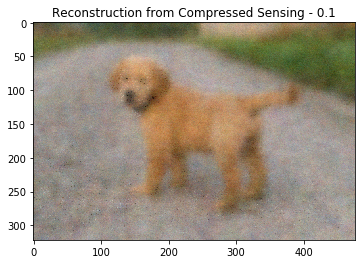

In [50]:
plt.imshow(Z[0]);
plt.title('Reconstruction from Compressed Sensing - 0.1');

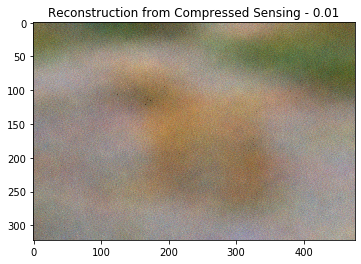

In [51]:
plt.imshow(Z[1])
plt.title('Reconstruction from Compressed Sensing - 0.01');